### Market Segmentation of Travel Mode Choice

This notebook contains the code and describes the process of estimating a latent class choice model of transport mode choice. The data used for this exercise is from the capitol region of Connecticut - Hartford metropolitan area. The data cannot be shared here due to restrictions. This notebook heavily borrows from Feras El Zarwi's example notebook on the LCCM package. 

### Import Libraries

In [1]:
import lccm
import numpy as np
import pandas as pd
import pylogit as pl
import warnings
from collections import OrderedDict
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
pd.options.display.max_columns = 50

### Read Data

In [3]:
hdf = pd.HDFStore('./hdf5_pandas.h5', mode = 'r')

In [4]:
hdf.keys()

/Users/albab.noor/anaconda/lib/python2.7/site-packages/tables/leaf.py:394: PerformanceWarning: The Leaf ``/tph/_i_table/comments/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


['/hh', '/prep_data', '/tph', '/tt_google', '/tt_skim']

In [5]:
df = hdf.get('/prep_data') # prepared data for hartford area with dummy variables and travel time data merged

In [6]:
df.drop(df.columns[0], axis=1, inplace = True)

In [7]:
df[10:20]

,hhid,personid,linked_tripid,hhsize,numvehicle,numbicycle,numkids,numstudents,renter,low_income,mid_income,high_income,age,age_broad,male,silent,boomer,gen_x,millenial,gen_z,employed,grad_degree,TOI,Auto_TD,Transit_TD,Walk_TD,Auto_TT,Transit_TT,Walk_TT,Mode_Choice,HBW,HBO,WBT,NHB,SOV_AV,HOV_AV,Transit_AV,Walk_AV
10,16100141,1610014101,1610014101030,2,2,2,0,0,0,0,0,1,37,7,0,0,0,1,0,0,1,0,0.000000,0.75,0.75,0.75,3,15,15,1.0,0,0,0,1,1,1,1,1
11,16100141,1610014101,1610014101040,2,2,2,0,0,0,0,0,1,37,7,0,0,0,1,0,0,1,0,1.374283,1.86,1.86,1.86,9,36,36,1.0,0,0,0,1,1,1,1,1
12,16100141,1610014101,1610014101050,2,2,2,0,0,0,0,0,1,37,7,0,0,0,1,0,0,1,0,2.104005,0.69,0.58,0.58,3,12,12,1.0,0,1,0,0,1,1,1,1
13,16100141,1610014102,1610014102040,2,2,2,0,0,0,0,0,1,52,8,1,0,0,1,0,0,1,0,0.369175,3.14,-99.00,3.14,12,-99,61,1.0,0,1,0,0,1,1,0,1
14,16100145,1610014501,1610014501010,1,1,0,0,0,0,0,1,0,65,10,0,0,1,0,0,0,1,0,4.091716,7.99,8.72,7.20,14,56,145,1.0,1,0,0,0,1,1,1,0
15,16100145,1610014501,1610014501020,1,1,0,0,0,0,0,1,0,65,10,0,0,1,0,0,0,1,0,6.006115,10.08,10.69,8.19,13,30,166,1.0,0,0,1,0,1,1,1,0
16,16100145,1610014501,1610014501030,1,1,0,0,0,0,0,1,0,65,10,0,0,1,0,0,0,1,0,3.975230,3.16,-99.00,3.13,8,-99,63,1.0,0,1,0,0,1,1,0,1
17,16100197,1610019701,1610019701010,3,3,4,1,1,0,0,0,1,51,8,0,0,0,1,0,0,1,1,4.778088,3.95,4.71,3.93,11,22,79,1.0,0,1,0,0,1,1,1,1
18,16100197,1610019701,1610019701020,3,3,4,1,1,0,0,0,1,51,8,0,0,0,1,0,0,1,1,5.132420,1.67,2.01,1.62,6,12,32,1.0,0,0,0,1,1,1,1,1
19,16100197,1610019701,1610019701030,3,3,4,1,1,0,0,0,1,51,8,0,0,0,1,0,0,1,1,5.032595,2.64,3.76,2.64,11,25,53,1.0,0,0,0,1,1,1,1,1


In [8]:
df.shape

(22017, 38)

### Separate DFs for Purposes

In [15]:
df['Work_Trips'] = ((df['HBW'] == 1) | (df['WBT'] == 1)).astype(int)

In [16]:
df['Work_Trips'].value_counts()

0    16195
1     5822
Name: Work_Trips, dtype: int64

In [18]:
df.shape

(22017, 39)

In [19]:
df[['hhsize', 'numkids', 'numvehicle', 'numbicycle', 'high_income', 'mid_income', 'low_income', 'male', 'gen_z', 'millenial', 'gen_x', 'boomer', 'silent', 'employed', 'grad_degree', 'TOI', 'Auto_TT', 'Transit_TT', 'Walk_TT', 'Work_Trips']].describe().T

,count,mean,std,min,25%,50%,75%,max
hhsize,22017.0,2.371349,1.210980,1.0,2.0,2.000000,3.00000,8.000000
numkids,22017.0,0.440251,0.854134,0.0,0.0,0.000000,1.00000,6.000000
numvehicle,22017.0,1.946996,1.054715,0.0,1.0,2.000000,2.00000,9.000000
numbicycle,22017.0,1.290684,1.533268,0.0,0.0,1.000000,2.00000,5.000000
high_income,22017.0,0.383431,0.486233,0.0,0.0,0.000000,1.00000,1.000000
mid_income,22017.0,0.435663,0.495855,0.0,0.0,0.000000,1.00000,1.000000
low_income,22017.0,0.180906,0.384949,0.0,0.0,0.000000,0.00000,1.000000
male,22017.0,0.445701,0.497054,0.0,0.0,0.000000,1.00000,1.000000
gen_z,22017.0,0.008266,0.090545,0.0,0.0,0.000000,0.00000,1.000000
millenial,22017.0,0.160285,0.366879,0.0,0.0,0.000000,0.00000,1.000000


## Model Data Preparation

In [28]:
ind_variables = ['hhid', 'personid', 'linked_tripid', 'hhsize', 'numvehicle', 'numbicycle', 'numkids', 'renter',
                'low_income', 'mid_income', 'high_income', 'age', 'age_broad', 'male', 'silent', 'boomer', 'gen_x',
                'millenial', 'gen_z', 'employed', 'grad_degree', 'TOI', 'HBW', 'HBO', 'WBT', 'NHB', 'Work_Trips']

alt_varying_variables = {u'travel_time': dict([(1, 'Auto_TT'),
                                               (2, 'Auto_TT'),
                                               (3, 'Transit_TT'),
                                               (4, 'Walk_TT')]),
                        u'travel_distance': dict([(1, 'Auto_TD'),
                                               (2, 'Auto_TD'),
                                               (3, 'Transit_TD'),
                                               (4, 'Walk_TD')])}

availability_variables = {1: 'SOV_AV',
                          2: 'HOV_AV',
                          3: 'Transit_AV',
                          4: 'Walk_AV'}

custom_alt_id = "mode_id"

obs_id_column = "custom_id"
df[obs_id_column] = np.arange(df.shape[0],
                                            dtype=int) + 1

choice_column = "Mode_Choice"

In [29]:
type(ind_variables)

list

In [30]:
long_data = pl.convert_wide_to_long(df, 
                                    ind_variables, 
                                    alt_varying_variables, 
                                    availability_variables, 
                                    obs_id_column, 
                                    choice_column,
                                    new_alt_id_name=custom_alt_id)

/Users/albab.noor/anaconda/lib/python2.7/site-packages/pylogit/choice_tools.py:421: UserWarning: Note, there are 40 variables in wide_data but the inputs ind_vars, alt_specific_vars, and subset_specific_vars only account for 39 variables.
  msg_2 + msg_3.format(num_vars_accounted_for))


In [31]:
long_data.head()

,custom_id,mode_id,Mode_Choice,hhid,personid,linked_tripid,hhsize,numvehicle,numbicycle,numkids,renter,low_income,mid_income,high_income,age,age_broad,male,silent,boomer,gen_x,millenial,gen_z,employed,grad_degree,TOI,HBW,HBO,WBT,NHB,Work_Trips,travel_time,travel_distance
0,1,1,1,16100054,1610005401,1610005401010,2,2,0,0,0,0,1,0,84,11,1,1,0,0,0,0,0,0,4.359653,0,1,0,0,0,5,2.01
1,1,2,0,16100054,1610005401,1610005401010,2,2,0,0,0,0,1,0,84,11,1,1,0,0,0,0,0,0,4.359653,0,1,0,0,0,5,2.01
2,1,3,0,16100054,1610005401,1610005401010,2,2,0,0,0,0,1,0,84,11,1,1,0,0,0,0,0,0,4.359653,0,1,0,0,0,19,4.32
3,1,4,0,16100054,1610005401,1610005401010,2,2,0,0,0,0,1,0,84,11,1,1,0,0,0,0,0,0,4.359653,0,1,0,0,0,41,2.00
4,2,1,1,16100054,1610005401,1610005401020,2,2,0,0,0,0,1,0,84,11,1,1,0,0,0,0,0,0,4.536460,0,0,0,1,0,7,2.73


In [32]:
n_classes = 4

In [33]:
class_membership_spec = ['intercept', 'hhsize', 'numvehicle', 'numkids', 'numbicycle', 'high_income', 'mid_income', 'male', 'employed', 'millenial', 'gen_x', 'boomer', 'silent', 'grad_degree']

class_membership_labels = ['Class-specific constant', 'hhsize', 'numvehicle', 'numkids', 'numbicycle', 'high_income', 'mid_income', 'male', 'employed', 'millenial', 'gen_x', 'boomer', 'silent', 'grad_degree']

In [34]:
avail_alts = (np.array([1,2,3,4]),
              np.array([1,2,3,4]),
              np.array([1,2,3,4]),
              np.array([1,2,3,4]))

In [35]:
class_specific_specs = [
                        
                        OrderedDict([
            
                                     ('intercept', [1,3,4]), 
                                     ('travel_time', [[1,2],3,4]), 
                                     ('TOI', [1,3,4])
            
                                    ]),
    
                        OrderedDict([
            
                                     ('intercept', [1,3,4]), 
                                     ('travel_time', [[1,2],3,4]), 
                                     ('TOI', [1,3,4])
            
                                    ]),
    
                        OrderedDict([
            
                                     ('intercept', [1,3,4]), 
                                     ('travel_time', [[1,2],3,4]), 
                                     ('TOI', [1,3,4])
            
                                    ]),
    
                        OrderedDict([
            
                                     ('intercept', [1,3,4]), 
                                     ('travel_time', [[1,2],3,4]), 
                                     ('TOI', [1,3,4])
            
                                    ])
                       ]
                       
class_specific_labels = [
    
                         OrderedDict([
            
                                    ('ASC', ['Drive Alone', 'Public Transit', 'Active Mode']),
                                      
                                    ('Travel Time', ['Travel Time (DA-SR)', 
                                                     'Travel Time (Public Transit)', 'Travel Time (Walking)']),
                                      
                                    ('TOI', ['TOI (Drive Alone)', 'TOI (Public Transit)', 'TOI (Active Mode)'])
                             
                             
                                    ]),
    
                         OrderedDict([
            
                                    ('ASC', ['Drive Alone', 'Public Transit', 'Active Mode']),
                                      
                                    ('Travel Time', ['Travel Time (DA-SR)', 
                                                     'Travel Time (Public Transit)', 'Travel Time (Walking)']),
                                      
                                    ('TOI', ['TOI (Drive Alone)', 'TOI (Public Transit)', 'TOI (Active Mode)'])
                             
                             
                                    ]),
    
                         OrderedDict([
            
                                    ('ASC', ['Drive Alone', 'Public Transit', 'Active Mode']),
                                      
                                    ('Travel Time', ['Travel Time (DA-SR)',
                                                     'Travel Time (Public Transit)', 'Travel Time (Walking)']),
                                      
                                   ('TOI', ['TOI (Drive Alone)', 'TOI (Public Transit)', 'TOI (Active Mode)'])
                             
                             
                                    ]),
    
                        OrderedDict([
            
                                    ('ASC', ['Drive Alone', 'Public Transit', 'Active Mode']),
                                      
                                    ('Travel Time', ['Travel Time (DA-SR)',
                                                     'Travel Time (Public Transit)', 'Travel Time (Walking)']),
                                      
                                    ('TOI', ['TOI (Drive Alone)', 'TOI (Public Transit)', 'TOI (Active Mode)'])
                             
                             
                                    ])
                        
                        ]

In [36]:
# Specify starting values for model parameters

# Class membership model parameters
paramClassMem = np.array([-0.2095, -2.0936, 0.7840, -0.0300, -0.6398, -1.1167, -1.1688, 0.6159, 0.8560, -0.5191, 0.6347,
                         -0.3638, 0.3666, 0.1120, 0.0126, -0.4458, 0.1272, -0.4998, -0.8493, -0.0534, -0.4507, 0.3502,
                         -0.0216, 0.0392, 0.5195, 1.2947, 1.4915, 1.9725, 1.9776, 0.6416, 1.9094, 2.4492, 0.9709, 1.5270,
                         2.3691, 1.0714, -0.0388, 2.3229, 0.9949, 0.3548, 0.2437, 0.0976])

# Class specific choice model parameters
paramClassSpec = []
for s in range(0, n_classes):
    paramClassSpec.append(np.array([-5.0860, -0.7397, -9.6365, 0.0680, 0.0048, -0.0110, -0.3485, 19.5931, 17.9402, 21.2471,
                                   -0.0334, -0.0586, 0.7304])),
    paramClassSpec.append(np.array([-3.2753, -4.3576, -3.0267, -0.0776, -0.0377, -0.0341, -0.0828, -0.0853, -3.8040, -0.3444,
                                   -0.0076, -0.0385, 0.1772])),
    paramClassSpec.append(np.array([-0.3658, 0.3369, -16.2147, -0.0099, -0.0183, 0.0025, -0.1683, -0.0104, -2.1550, -1.0271,
                                   -0.2640, -0.2606, 1.6527]))
    paramClassSpec.append(np.array([-0.3995, -4.9123, -31.8940, 0.5584, -0.2367, 0.0124, -0.0705, 1.3415, 2.4754, 25.8636,
                                   -0.0544, 0.2599, 0.9157]))

## Model Estimation

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    lccm.lccm_fit(data = long_data,
                  ind_id_col = 'personid', 
                  obs_id_col = 'custom_id',
                  alt_id_col = 'mode_id',
                  choice_col = 'Mode_Choice', 
                  n_classes = n_classes,
                  class_membership_spec = class_membership_spec,
                  class_membership_labels = class_membership_labels,
                  class_specific_specs = class_specific_specs,
                  class_specific_labels = class_specific_labels,
                  avail_alts = avail_alts,
                  #paramClassMem = paramClassMem,
                  #paramClassSpec = paramClassSpec,
                  #indWeights = indWeights,
                  outputFilePath = './New_LCCM_Vij/')

Processing data
Initializing EM Algorithm...

<Tue, 10 Apr 2018 08:21:06> Iteration 0: -23782.9855
<Tue, 10 Apr 2018 08:21:06> Iteration 1: -16641.4215
<Tue, 10 Apr 2018 08:21:07> Iteration 2: -15776.1234
<Tue, 10 Apr 2018 08:21:08> Iteration 3: -14705.6797
<Tue, 10 Apr 2018 08:21:09> Iteration 4: -13684.4213
<Tue, 10 Apr 2018 08:21:10> Iteration 5: -13240.4328
<Tue, 10 Apr 2018 08:21:10> Iteration 6: -13068.7093
<Tue, 10 Apr 2018 08:21:11> Iteration 7: -12958.5868
<Tue, 10 Apr 2018 08:21:11> Iteration 8: -12881.3390
<Tue, 10 Apr 2018 08:21:12> Iteration 9: -12830.9543
<Tue, 10 Apr 2018 08:21:13> Iteration 10: -12799.1314
<Tue, 10 Apr 2018 08:21:14> Iteration 11: -12779.0583
<Tue, 10 Apr 2018 08:21:14> Iteration 12: -12765.6842
<Tue, 10 Apr 2018 08:21:15> Iteration 13: -12756.5303
<Tue, 10 Apr 2018 08:21:16> Iteration 14: -12749.7160
<Tue, 10 Apr 2018 08:21:16> Iteration 15: -12744.1718
<Tue, 10 Apr 2018 08:21:17> Iteration 16: -12740.0313
<Tue, 10 Apr 2018 08:21:18> Iteration 17: -127

In [146]:
llfitted = -11906.49
llnull = -26412.72
lratio = round(2*(llfitted - llnull))

chi = stats.distributions.chi2.sf(lratio, 84)

print (lratio, chi)

(29012.0, 0.0)


In [147]:
results = pd.read_csv('./ModelResultsSampleEnum.csv')

In [148]:
results.shape

(5309, 21)

In [149]:
results.columns = ['personid', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'SOV_1', 'HOV_1', 'Transit_1', 'Walk_1', 'SOV_2', 'HOV_2', 'Transit_2', 'Walk_2', 'SOV_3', 'HOV_3', 'Transit_3', 'Walk_3', 'SOV_4', 'HOV_4', 'Transit_4', 'Walk_4']

In [150]:
results.head()

,personid,Class_1,Class_2,Class_3,Class_4,SOV_1,HOV_1,Transit_1,Walk_1,SOV_2,HOV_2,Transit_2,Walk_2,SOV_3,HOV_3,Transit_3,Walk_3,SOV_4,HOV_4,Transit_4,Walk_4
0,1.610005e+09,0.479867,0.009119,0.243088,0.267926,1.991623,0.000395,0.007982,3.016086e-08,0.883820,0.168952,0.677561,0.269666,1.178831,0.821169,1.562428e-200,2.359450e-07,0.038174,1.956989,5.862120e-04,0.004250
1,1.610012e+09,0.023325,0.051616,0.826854,0.098205,2.991751,0.000362,0.007318,5.690890e-04,1.836247,0.308776,0.308846,0.546131,1.718906,1.279864,2.476309e-200,1.230585e-03,0.056047,2.735383,1.633330e-04,0.208407
2,1.610014e+09,0.519721,0.139361,0.299291,0.041628,4.965955,0.000225,0.003356,3.046321e-02,1.779617,0.163518,0.963597,2.093268,3.149346,1.771189,6.598757e-04,7.880469e-02,0.624784,4.118935,7.370077e-08,0.256281
3,1.610014e+09,0.498131,0.200395,0.263143,0.038332,0.999975,0.000025,0.000000,2.433063e-09,0.711560,0.108023,0.000000,0.180417,0.568459,0.431541,0.000000e+00,4.469262e-08,0.014841,0.984714,0.000000e+00,0.000445
4,1.610015e+09,0.741626,0.051938,0.168648,0.037789,2.993495,0.000596,0.005909,4.501367e-09,1.886567,0.345002,0.635318,0.133113,1.793504,1.206496,1.767149e-200,3.247266e-08,0.064621,2.912102,1.787102e-02,0.005405


In [151]:
df['TOI'].describe()

count    22017.000000
mean         2.561372
std          2.165391
min          0.000000
25%          0.000000
50%          2.891581
75%          4.553170
max          6.345862
Name: TOI, dtype: float64

In [152]:
classes = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
modes1 = ['SOV_1', 'HOV_1', 'Transit_1', 'Walk_1']
modes2 = ['SOV_2', 'HOV_2', 'Transit_2', 'Walk_2']
modes3 = ['SOV_3', 'HOV_3', 'Transit_3', 'Walk_3']
modes4 = ['SOV_4', 'HOV_4', 'Transit_4', 'Walk_4']
#modes5 = ['SOV_5', 'HOV_5', 'Transit_5', 'Walk_5']

class_membership = []

for cm in range(4):
    class_membership.append(100*results[classes[cm]].mean())

class1 = []
class2 = []
class3 = []
class4 = []
#class5 = []


for m in modes1:
    class1.append((results[classes[0]]*results[m]).sum())

for m in modes2:
    class2.append((results[classes[1]]*results[m]).sum())
    
for m in modes3:
    class3.append((results[classes[2]]*results[m]).sum())
    
for m in modes4:
    class4.append((results[classes[3]]*results[m]).sum())

'''for m in modes5:
    class5.append((results[classes[4]]*results[m]).sum())'''
        

percentage1 = []
percentage2 = []
percentage3 = []
percentage4 = []
#percentage5 = []

modes = ['Drive Alone', 'Shared Ride', 'Public Transit', 'Walking']

for i in range(4):
    percentage1.append(class1[i]*100/sum(class1))
    
for i in range(4):
    percentage2.append(class2[i]*100/sum(class2))
    
for i in range(4):
    percentage3.append(class3[i]*100/sum(class3))
    
for i in range(4):
    percentage4.append(class4[i]*100/sum(class4))
    
'''for i in range(4):
    percentage5.append(class5[i]*100/sum(class5))'''

'for i in range(4):\n    percentage5.append(class5[i]*100/sum(class5))'

In [153]:
class_membership

[45.39467811768508, 13.525735608719355, 28.885960738664856, 12.193625534931218]

In [154]:
percentage_list = pd.DataFrame(
    {'Modes': modes,
     'Class1': percentage1,
     'Class2': percentage2,
     'Class3': percentage3,
     'Class4': percentage4}
    )

In [155]:
trans = percentage_list.T
trans = trans.reset_index()

In [156]:
trans.columns = trans.iloc[4]
#trans.reindex(trans.index.drop(4))

In [157]:
trans.columns = ['Classes', 'Drive Alone', 'Shared Ride', 'Public Transit', 'Walking']

In [158]:
trans = trans.drop(4)
trans = pd.DataFrame(trans)
trans

,Classes,Drive Alone,Shared Ride,Public Transit,Walking
0,Class1,92.5362,0.182901,2.00924,5.27163
1,Class2,46.6085,8.38501,11.8058,33.2007
2,Class3,54.3275,41.2315,0.012357,4.42862
3,Class4,1.94426,89.9526,1.37187,6.73127


In [159]:
membership = pd.Series(class_membership)
trans['Class Membership'] = membership.values

In [160]:
trans

,Classes,Drive Alone,Shared Ride,Public Transit,Walking,Class Membership
0,Class1,92.5362,0.182901,2.00924,5.27163,45.394678
1,Class2,46.6085,8.38501,11.8058,33.2007,13.525736
2,Class3,54.3275,41.2315,0.012357,4.42862,28.885961
3,Class4,1.94426,89.9526,1.37187,6.73127,12.193626


In [161]:
percentage_list

,Class1,Class2,Class3,Class4,Modes
0,92.536226,46.608477,54.327488,1.944263,Drive Alone
1,0.182901,8.385009,41.231531,89.952600,Shared Ride
2,2.009239,11.805768,0.012357,1.371869,Public Transit
3,5.271633,33.200745,4.428624,6.731268,Walking


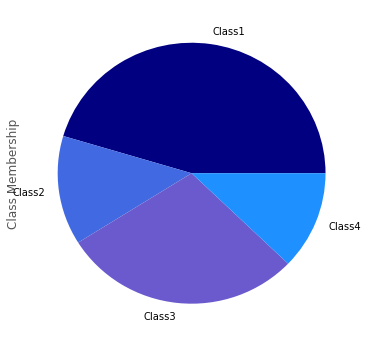

In [162]:
trans.plot.pie(labels = trans['Classes'], y = 'Class Membership', figsize = (6,6), legend = False, rot = 0, colors = ['navy', 'royalblue', 'slateblue',  'dodgerblue']);

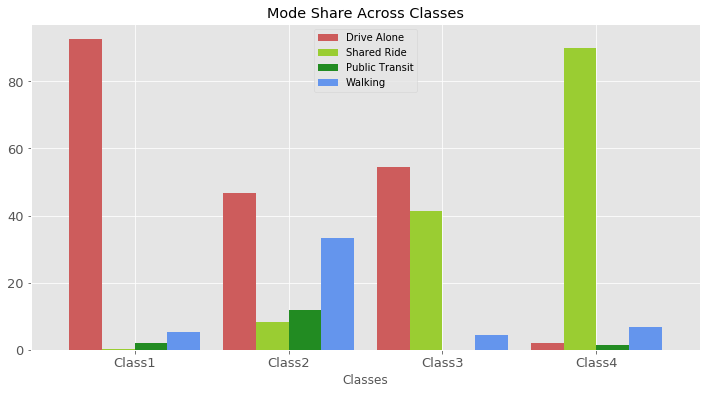

In [163]:
trans.plot.bar(x = 'Classes', y = ['Drive Alone', 'Shared Ride', 'Public Transit', 'Walking'], width = 0.85, figsize = (12,6), rot = 0, color = ['indianred', 'yellowgreen', 'forestgreen', 'cornflowerblue'], fontsize = 13, title = 'Mode Share Across Classes');

## Socioeconomic Composition

In [164]:
df.shape, results.shape

((22017, 40), (5309, 21))

In [165]:
composition = pd.merge(results, df, on = 'personid', how = 'right')

In [166]:
composition.shape

(22017, 60)

In [167]:
composition_drop = composition.drop_duplicates('personid', keep = 'first')

In [168]:
composition_drop.shape

(5310, 60)

In [169]:
composition_drop.head()

,personid,Class_1,Class_2,Class_3,Class_4,SOV_1,HOV_1,Transit_1,Walk_1,SOV_2,HOV_2,Transit_2,Walk_2,SOV_3,HOV_3,Transit_3,Walk_3,SOV_4,HOV_4,Transit_4,Walk_4,hhid,linked_tripid,hhsize,numvehicle,...,silent,boomer,gen_x,millenial,gen_z,employed,grad_degree,TOI,Auto_TD,Transit_TD,Walk_TD,Auto_TT,Transit_TT,Walk_TT,Mode_Choice,HBW,HBO,WBT,NHB,SOV_AV,HOV_AV,Transit_AV,Walk_AV,Work_Trips,custom_id
0,1.610005e+09,0.479867,0.009119,0.243088,0.267926,1.991623,0.000395,0.007982,3.016086e-08,0.883820,0.168952,0.677561,0.269666,1.178831,0.821169,1.562428e-200,2.359450e-07,0.038174,1.956989,5.862120e-04,0.004250,16100054,1610005402010,2,2,...,1,0,0,0,0,0,0,4.359653,2.90,2.92,2.90,10,19,58,1.0,0,1,0,0,1,1,1,1,0,4
2,1.610012e+09,0.023325,0.051616,0.826854,0.098205,2.991751,0.000362,0.007318,5.690890e-04,1.836247,0.308776,0.308846,0.546131,1.718906,1.279864,2.476309e-200,1.230585e-03,0.056047,2.735383,1.633330e-04,0.208407,16100124,1610012402020,6,2,...,0,0,1,0,0,1,1,2.417367,5.88,10.30,8.11,8,38,161,1.0,0,0,1,0,1,1,1,0,1,6
5,1.610014e+09,0.519721,0.139361,0.299291,0.041628,4.965955,0.000225,0.003356,3.046321e-02,1.779617,0.163518,0.963597,2.093268,3.149346,1.771189,6.598757e-04,7.880469e-02,0.624784,4.118935,7.370077e-08,0.256281,16100141,1610014101010,2,2,...,0,0,1,0,0,1,0,2.104005,29.69,53.45,26.23,48,151,534,1.0,1,0,0,0,1,1,1,0,1,9
10,1.610014e+09,0.498131,0.200395,0.263143,0.038332,0.999975,0.000025,0.000000,2.433063e-09,0.711560,0.108023,0.000000,0.180417,0.568459,0.431541,0.000000e+00,4.469262e-08,0.014841,0.984714,0.000000e+00,0.000445,16100141,1610014102040,2,2,...,0,0,1,0,0,1,0,0.369175,3.14,-99.00,3.14,12,-99,61,1.0,0,1,0,0,1,1,0,1,0,14
11,1.610015e+09,0.741626,0.051938,0.168648,0.037789,2.993495,0.000596,0.005909,4.501367e-09,1.886567,0.345002,0.635318,0.133113,1.793504,1.206496,1.767149e-200,3.247266e-08,0.064621,2.912102,1.787102e-02,0.005405,16100145,1610014501010,1,1,...,0,1,0,0,0,1,0,4.091716,7.99,8.72,7.20,14,56,145,1.0,1,0,0,0,1,1,1,0,1,15


In [170]:
classes = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
demogs = ['hhsize', 'numvehicle', 'numkids', 'numbicycle', 'high_income', 'mid_income', 'low_income', 
          'gen_z', 'millenial', 'boomer', 'gen_x', 'silent', 'male', 'grad_degree', 'employed', 'TOI']

In [171]:
comp = []
names = []

for c in classes:
    for d in demogs:
        comp.append(((composition_drop[c]*composition_drop[d]).sum())/((composition_drop[c]).sum()))
        names.append(c+'_'+d)

In [172]:
len(comp), len(names)

(64, 64)

In [173]:
names[4:7], comp[4:7]

(['Class_1_high_income', 'Class_1_mid_income', 'Class_1_low_income'],
 [0.3541273945096118, 0.44363730707970506, 0.2022352984106769])

In [174]:
#composition_drop.loc[:, "class1_millenials"] = composition_drop.loc[:, 'Class_1']*composition_drop.loc[:, 'millenial']

In [175]:
A = np.array(comp)
B = np.reshape(A, (-1, 16))

In [176]:
comp_df = pd.DataFrame(B)

In [177]:
comp_df.columns = ['hhsize', 'numvehicle', 'numkids', 'numbicycle', 'high_income', 'mid_income', 'low_income', 
          'gen_z', 'millenial', 'boomer', 'gen_x', 'silent', 'male', 'grad_degree', 'employed', 'TOI']

In [178]:
comp_df

,hhsize,numvehicle,numkids,numbicycle,high_income,mid_income,low_income,gen_z,millenial,boomer,gen_x,silent,male,grad_degree,employed,TOI
0,1.991620,1.983461,0.137507,0.890637,0.354127,0.443637,0.202235,0.004308,0.159026,0.508805,0.244150,0.083711,0.451876,0.227768,0.678135,2.169628
1,2.492530,1.639083,0.436513,1.439355,0.386323,0.347663,0.266014,0.002921,0.266699,0.363488,0.356327,0.010565,0.542287,0.300259,0.632103,2.466684
2,2.881581,2.178895,0.790870,1.738493,0.485536,0.408804,0.105660,0.007482,0.170103,0.349349,0.414380,0.058685,0.449347,0.300426,0.700924,2.024504
3,2.686736,1.831130,0.547319,1.110529,0.303608,0.496261,0.200132,0.054135,0.215294,0.395482,0.212017,0.123073,0.428624,0.200426,0.325764,2.218595


In [179]:
se = pd.Series(classes)
comp_df['Class'] = se.values

In [180]:
comp_df.loc[:, 'female'] = 1 - (comp_df.loc[:, 'male'])

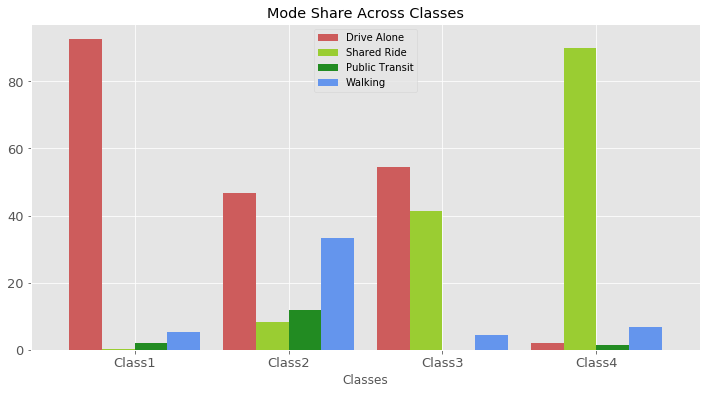

In [181]:
trans.plot.bar(x = 'Classes', y = ['Drive Alone', 'Shared Ride', 'Public Transit', 'Walking'], width = 0.85, figsize = (12,6), rot = 0, color = ['indianred', 'yellowgreen', 'forestgreen', 'cornflowerblue'], fontsize = 13, title = 'Mode Share Across Classes');

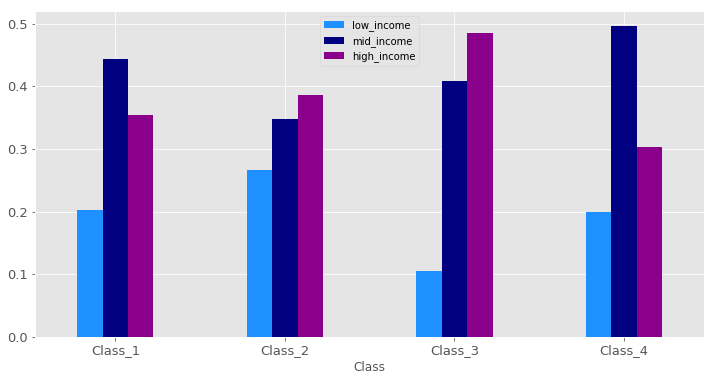

In [182]:
comp_df.plot.bar(x = 'Class', y = ['low_income', 'mid_income', 'high_income'], width = 0.45, figsize = (12,6), rot = 0, color = ['dodgerblue', 'navy', 'darkmagenta'], fontsize = 13);

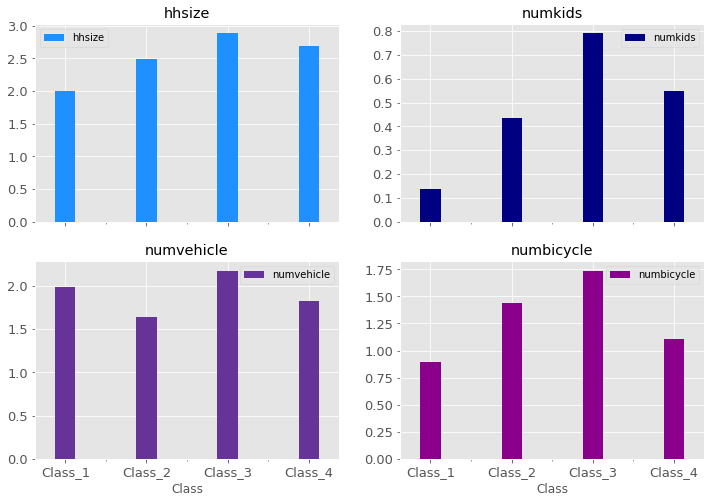

In [183]:
comp_df.plot.bar(x = 'Class', y = ['hhsize', 'numkids', 'numvehicle', 'numbicycle'], subplots = True, layout = (2,2), width = 0.25, figsize = (12,8), rot = 0, color = ['dodgerblue', 'navy', 'rebeccapurple', 'darkmagenta'], fontsize = 13);

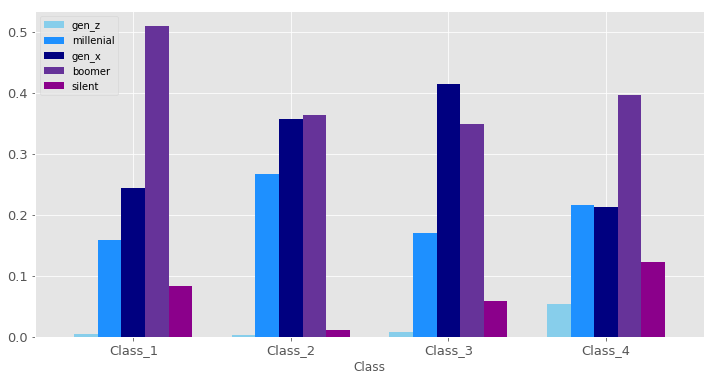

In [184]:
comp_df.plot.bar(x = 'Class', y = ['gen_z', 'millenial', 'gen_x', 'boomer', 'silent'], width = 0.75, figsize = (12,6), rot = 0, color = ['skyblue', 'dodgerblue', 'navy', 'rebeccapurple', 'darkmagenta'], fontsize = 13);

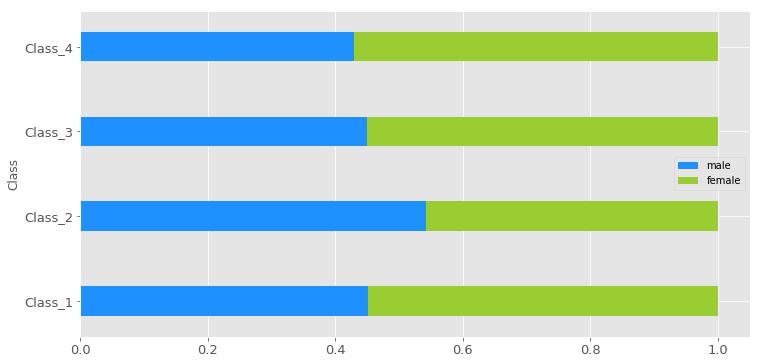

In [185]:
comp_df.plot.barh(x = 'Class', y = ['male', 'female'], stacked = True, width = 0.35, figsize = (12,6), rot = 0, color = ['dodgerblue', 'yellowgreen'], fontsize = 13);